# PyTorch Experiment Tracking drone detect system

## Datasets
I choosen pictures from:
- https://www.kaggle.com/datasets/umairatwork/manzoorumair-cloud-cover-dataset-muccd
- Open Images V7
- Cranfield Synthetic Drone Detection Dataset: https://huggingface.co/datasets/mazqtpopx/cranfield-synthetic-drone-detection

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [8]:
import zipfile
from pathlib import Path

zip_path = '/content/drive/MyDrive/Colab Notebooks/data_yolo.zip'
# data_path = Path("data/")
image_path = ""

with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(image_path)

Unzipping data...


In [9]:
import yaml
base_path = Path('data')

yaml_content = {
    'path': '/content/data',
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',

    'nc': 6,
    'names': {
        0: 'airplane',
        1: 'balloon',
        2: 'bird',
        3: 'drone',
        4: 'helicopter',
        5: 'sky'
    }
}

with open('data.yaml', 'w') as f:
    yaml.dump(yaml_content, f, sort_keys=False, default_flow_style=False)

In [10]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np

def on_train_epoch_end(trainer):
    try:
        current_epoch = trainer.epoch + 1

        # Training loss
        train_loss = [x.detach().cpu().numpy() for x in trainer.loss_items]

        # Validation metrics
        if trainer.validator:
            map50 = trainer.validator.metrics.box.map50
            metrics_text = f"mAP50: {map50:.2f}"
        else:
            metrics_text = ""

        # Tworzenie wykresów
        plt.figure(figsize=(12, 6))

        # Wykres strat treningowych
        plt.subplot(1, 2, 1)
        plt.plot(train_loss, label='Train Loss')
        plt.title(f'Epoch {current_epoch} - Loss')
        plt.legend()

        # Wyświetlanie metryk jako tekst
        plt.subplot(1, 2, 2)
        plt.text(0.1, 0.5, metrics_text, fontsize=12)
        plt.axis('off')

        # Zapis i zamknięcie
        plt.tight_layout()
        plt.savefig(f'epoch_{current_epoch}_metrics.png')
        plt.close()

    except Exception as e:
        print(f"Błąd w callbacku: {str(e)}")

# Model initialisation with callbacks
model = YOLO('yolov8n.pt')
model.add_callback('on_train_epoch_end', on_train_epoch_end)

# Configuration of hyperparameters
hyp = {
    'optimizer': 'SGD',
    'lr0': 0.01,              # Początkowy współczynnik uczenia (learning rate)
    'lrf': 0.1,               # Końcowy współczynnik uczenia
    'momentum': 0.937,        # Momentum dla optymalizatora SGD - pomaga uniknąć minimów lokalnych
    'weight_decay': 0.0005,   # Regularyzacja L2 - zapobiega przeuczeniu poprzez karanie dużych wartości wag
    'warmup_epochs': 3.0,     # Liczba epok rozgrzewki - stopniowe zwiększanie learning rate na początku treningu
    'box': 7.5,               # Współczynnik straty dla lokalizacji bounding box (im wyższa wartość, tym większy nacisk na precyzję bboxów)
    'cls': 0.5,               # Współczynnik straty klasyfikacji (decyduje o wadze poprawnej klasyfikacji)
    'dfl': 1.5                # Współczynnik straty rozkładu (Distribution Focal Loss) - ważne dla małych obiektów
}

# Training
results = model.train(
    data='data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,
    project='aerial_detection',
    name='exp1',
    patience=20,              # zatrzyma trening jeśli brak poprawy przez 20 epok
    **hyp
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 105MB/s]


Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=aerial_detection, name=exp1, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

100%|██████████| 755k/755k [00:00<00:00, 21.2MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 114MB/s]


AMP: checks passed ✅


train: Scanning /content/data/labels/train... 4768 images, 28 backgrounds, 52 corrupt: 100%|██████████| 4789/4789 [00:04<00:00, 1172.25it/s]

train: WARNING ⚠️ /content/data/images/train/002bfa95f7788786.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     3.5578      6.8843]
train: WARNING ⚠️ /content/data/images/train/0036699dd6df5d5a.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        3.5      3.5161           7      6.9678]
train: WARNING ⚠️ /content/data/images/train/0047d58ff21c0342.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     18.664      36.672]
train: WARNING ⚠️ /content/data/images/train/0052af92b2733f48.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [          2           4]
train: WARNING ⚠️ /content/data/images/train/00a11d4e490a8e94.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [          2           3           4           6]
train: WARNING ⚠️ /content/data/images/train/00b4190b562b62eb.jpg: ignoring corrupt image/label: non-normalized or ou

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/labels/val... 1192 images, 9 backgrounds, 13 corrupt: 100%|██████████| 1200/1200 [00:01<00:00, 777.50it/s]

val: WARNING ⚠️ /content/data/images/val/0099506235997854.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       18.5           2          37           4]
val: WARNING ⚠️ /content/data/images/val/00996d4b5466073a.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      2.002      3.9961]
val: WARNING ⚠️ /content/data/images/val/00d2fbedb26dcccb.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [         31          31          62          62]
val: WARNING ⚠️ /content/data/images/val/0113e715883e4897.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [          2           4]
val: WARNING ⚠️ /content/data/images/val/0167463c8f74d5bc.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       12.5        12.5          25          25]
val: WARNING ⚠️ /content/data/images/val/017df37f9e64e4e6.jpg: ignoring corrupt image/label: non-normalized or ou

val: New cache created: /content/data/labels/val.cache
Plotting labels to aerial_detection/exp1/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to aerial_detection/exp1
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.13G       1.34      2.701      1.332         13        640: 100%|██████████| 297/297 [01:59<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:17<00:00,  2.22it/s]


                   all       1187       4706      0.491      0.505      0.446      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.75G      1.346      1.816      1.331          5        640: 100%|██████████| 297/297 [01:56<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.48it/s]


                   all       1187       4706      0.579      0.484       0.48      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.75G      1.409      1.807      1.379          3        640: 100%|██████████| 297/297 [01:51<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.60it/s]


                   all       1187       4706      0.442      0.365      0.344      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.77G      1.466      1.872      1.429          2        640: 100%|██████████| 297/297 [01:50<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.57it/s]


                   all       1187       4706      0.471      0.401      0.352      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.78G      1.463      1.795      1.418          3        640: 100%|██████████| 297/297 [01:50<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.65it/s]


                   all       1187       4706      0.597      0.455      0.458      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.79G      1.425      1.675      1.392          6        640: 100%|██████████| 297/297 [01:51<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.64it/s]


                   all       1187       4706      0.543      0.505      0.466      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.79G      1.408        1.6      1.376          2        640: 100%|██████████| 297/297 [01:52<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.53it/s]


                   all       1187       4706      0.619      0.513      0.533       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.81G       1.38      1.535      1.365         14        640: 100%|██████████| 297/297 [01:52<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.51it/s]


                   all       1187       4706      0.602      0.528      0.529      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.82G      1.346      1.493      1.356          1        640: 100%|██████████| 297/297 [01:52<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.47it/s]


                   all       1187       4706      0.609      0.542      0.551      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.84G      1.374      1.453      1.354         18        640: 100%|██████████| 297/297 [01:52<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.46it/s]


                   all       1187       4706      0.668      0.516      0.546      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.84G      1.334       1.39      1.325          3        640: 100%|██████████| 297/297 [01:52<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.48it/s]


                   all       1187       4706      0.649      0.562      0.568      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.86G      1.303      1.382      1.319          2        640: 100%|██████████| 297/297 [01:51<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.56it/s]


                   all       1187       4706      0.678      0.559      0.587      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.87G      1.303      1.352      1.305          3        640: 100%|██████████| 297/297 [01:54<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.41it/s]


                   all       1187       4706      0.705      0.582      0.603      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.88G      1.314      1.326      1.315          9        640: 100%|██████████| 297/297 [01:52<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.67it/s]


                   all       1187       4706      0.667      0.567      0.579      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.88G      1.303      1.314      1.307          1        640: 100%|██████████| 297/297 [01:50<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]


                   all       1187       4706      0.697      0.577      0.598      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       3.9G      1.298      1.277      1.297          7        640: 100%|██████████| 297/297 [01:48<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.67it/s]


                   all       1187       4706      0.737      0.571      0.617      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.91G      1.258       1.24      1.283          1        640: 100%|██████████| 297/297 [01:51<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.53it/s]

                   all       1187       4706       0.72      0.573       0.62      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.92G       1.28      1.248      1.294          2        640: 100%|██████████| 297/297 [01:52<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.56it/s]


                   all       1187       4706      0.714      0.574       0.62      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.93G      1.256      1.224      1.274         10        640: 100%|██████████| 297/297 [01:50<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.59it/s]


                   all       1187       4706      0.718       0.59       0.63      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.95G      1.249      1.207      1.278          1        640: 100%|██████████| 297/297 [01:52<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.57it/s]


                   all       1187       4706      0.726      0.619      0.645      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.38G      1.227      1.175      1.266          2        640: 100%|██████████| 297/297 [01:51<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.63it/s]


                   all       1187       4706      0.712      0.599      0.632      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.39G      1.233      1.164      1.264          1        640: 100%|██████████| 297/297 [01:50<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.68it/s]


                   all       1187       4706      0.741      0.605      0.634      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.39G      1.227      1.166      1.269          2        640: 100%|██████████| 297/297 [02:00<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.43it/s]


                   all       1187       4706      0.726      0.603      0.642      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.41G      1.226      1.155      1.258          6        640: 100%|██████████| 297/297 [02:02<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:18<00:00,  2.06it/s]


                   all       1187       4706      0.718      0.616       0.64      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.42G      1.205      1.108       1.25          4        640: 100%|██████████| 297/297 [02:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:17<00:00,  2.20it/s]


                   all       1187       4706      0.743       0.59      0.634      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.44G      1.229      1.121      1.258          4        640: 100%|██████████| 297/297 [02:05<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:16<00:00,  2.33it/s]


                   all       1187       4706      0.758       0.61      0.655      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.44G      1.205      1.106      1.239          2        640: 100%|██████████| 297/297 [02:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.59it/s]


                   all       1187       4706       0.74      0.633       0.67      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.46G      1.213        1.1       1.25          2        640: 100%|██████████| 297/297 [01:53<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.44it/s]


                   all       1187       4706      0.704      0.612      0.651      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.47G      1.196      1.073      1.241          5        640: 100%|██████████| 297/297 [01:54<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.51it/s]


                   all       1187       4706      0.732      0.626      0.653      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.93G      1.211      1.087      1.242          4        640: 100%|██████████| 297/297 [01:54<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:16<00:00,  2.36it/s]


                   all       1187       4706      0.767      0.642      0.676      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.93G      1.167      1.053       1.22         18        640: 100%|██████████| 297/297 [01:54<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.41it/s]


                   all       1187       4706      0.739      0.618      0.658      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.95G      1.177      1.048      1.225          5        640: 100%|██████████| 297/297 [01:55<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]


                   all       1187       4706      0.731      0.643      0.663      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.96G      1.195      1.081      1.229          1        640: 100%|██████████| 297/297 [01:53<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.49it/s]


                   all       1187       4706      0.741      0.616      0.653      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.97G      1.175      1.037      1.219         12        640: 100%|██████████| 297/297 [01:58<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.46it/s]


                   all       1187       4706      0.746      0.643      0.675      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.97G      1.171      1.027       1.22          6        640: 100%|██████████| 297/297 [01:56<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.44it/s]


                   all       1187       4706      0.782      0.611       0.67      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.99G      1.199      1.052      1.226          1        640: 100%|██████████| 297/297 [01:52<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]


                   all       1187       4706      0.745      0.636      0.664      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         5G      1.166      1.014      1.219          4        640: 100%|██████████| 297/297 [01:49<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.39it/s]


                   all       1187       4706      0.757      0.632      0.671      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.02G       1.15     0.9958       1.21          8        640: 100%|██████████| 297/297 [01:49<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]


                   all       1187       4706      0.751      0.652       0.68      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.02G      1.163     0.9863      1.217          3        640: 100%|██████████| 297/297 [01:48<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.63it/s]


                   all       1187       4706      0.803      0.644      0.686       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.04G      1.164     0.9811      1.205          2        640: 100%|██████████| 297/297 [01:53<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.61it/s]

                   all       1187       4706      0.762      0.649      0.685      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.05G       1.15     0.9854       1.21          6        640: 100%|██████████| 297/297 [01:55<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.65it/s]


                   all       1187       4706      0.765      0.663       0.69      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.06G      1.152     0.9676      1.208         15        640: 100%|██████████| 297/297 [01:50<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.61it/s]


                   all       1187       4706      0.789      0.643      0.685      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.06G      1.149     0.9619      1.203          5        640: 100%|██████████| 297/297 [01:49<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.61it/s]

                   all       1187       4706      0.774      0.638      0.686      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.08G      1.129     0.9478      1.196          4        640: 100%|██████████| 297/297 [01:50<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.61it/s]

                   all       1187       4706      0.787      0.651      0.699      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       5.1G      1.151     0.9464      1.197          3        640: 100%|██████████| 297/297 [01:51<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.59it/s]


                   all       1187       4706      0.769      0.663      0.704      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.11G      1.126       0.94      1.197          3        640: 100%|██████████| 297/297 [01:50<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.64it/s]


                   all       1187       4706      0.758      0.649      0.691      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.11G      1.132     0.9256      1.183          2        640: 100%|██████████| 297/297 [01:52<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.59it/s]


                   all       1187       4706      0.776       0.65      0.688      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.13G      1.127     0.9098      1.194          6        640: 100%|██████████| 297/297 [01:53<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.57it/s]


                   all       1187       4706      0.768       0.67        0.7      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.14G      1.125     0.9299      1.192          3        640: 100%|██████████| 297/297 [01:54<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.53it/s]


                   all       1187       4706      0.755       0.66      0.689      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.15G      1.105     0.9002      1.182          3        640: 100%|██████████| 297/297 [01:52<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.60it/s]


                   all       1187       4706      0.771      0.661      0.698      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.15G      1.121     0.9261      1.187          4        640: 100%|██████████| 297/297 [01:51<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.60it/s]


                   all       1187       4706      0.766      0.664      0.694      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.18G      1.104     0.8913       1.18         12        640: 100%|██████████| 297/297 [01:53<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]

                   all       1187       4706      0.784      0.661      0.708      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.19G      1.109     0.8807      1.176          3        640: 100%|██████████| 297/297 [01:52<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.48it/s]


                   all       1187       4706      0.801      0.666      0.713       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       5.2G       1.11     0.8899      1.183          2        640: 100%|██████████| 297/297 [01:51<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.48it/s]


                   all       1187       4706      0.759      0.668      0.701      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       5.2G      1.115     0.8889      1.182         37        640: 100%|██████████| 297/297 [01:52<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]


                   all       1187       4706      0.782      0.671      0.711      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.22G      1.084     0.8588      1.161          9        640: 100%|██████████| 297/297 [01:55<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:16<00:00,  2.34it/s]


                   all       1187       4706      0.777      0.675      0.708      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.23G      1.097     0.8758       1.17          4        640: 100%|██████████| 297/297 [01:51<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]


                   all       1187       4706       0.78      0.671      0.711      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.25G      1.079      0.857      1.168         19        640: 100%|██████████| 297/297 [01:51<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.52it/s]


                   all       1187       4706       0.77      0.687      0.714      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.25G      1.096     0.8521      1.168          3        640: 100%|██████████| 297/297 [01:51<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]


                   all       1187       4706      0.805      0.671      0.716      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.27G       1.09     0.8513      1.166         25        640: 100%|██████████| 297/297 [01:51<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.50it/s]


                   all       1187       4706      0.785      0.683      0.719      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.28G      1.084      0.846      1.164          6        640: 100%|██████████| 297/297 [01:51<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.63it/s]


                   all       1187       4706      0.802      0.656      0.707      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.29G      1.098     0.8548      1.173         13        640: 100%|██████████| 297/297 [01:51<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]


                   all       1187       4706      0.794      0.672      0.713      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.29G      1.062     0.8382      1.159          6        640: 100%|██████████| 297/297 [01:51<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.56it/s]


                   all       1187       4706      0.778      0.672       0.71      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.31G      1.074     0.8408      1.159          6        640: 100%|██████████| 297/297 [01:50<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]

                   all       1187       4706      0.782      0.673      0.709      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.32G      1.066      0.827      1.157          4        640: 100%|██████████| 297/297 [01:50<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.69it/s]


                   all       1187       4706       0.79      0.673      0.711      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.33G      1.076     0.8251      1.161          3        640: 100%|██████████| 297/297 [01:49<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.59it/s]


                   all       1187       4706      0.784      0.678      0.715      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.34G      1.074      0.817      1.157         17        640: 100%|██████████| 297/297 [01:53<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.64it/s]

                   all       1187       4706      0.801      0.671      0.717      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.36G      1.078     0.8116      1.149          4        640: 100%|██████████| 297/297 [01:52<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.65it/s]


                   all       1187       4706      0.818      0.668      0.715      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.37G      1.072     0.8209      1.153          2        640: 100%|██████████| 297/297 [01:51<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]

                   all       1187       4706      0.798      0.682       0.72      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.38G      1.069     0.8149      1.154          9        640: 100%|██████████| 297/297 [01:48<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.50it/s]


                   all       1187       4706      0.804      0.687      0.724      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.38G      1.078     0.8137      1.151          4        640: 100%|██████████| 297/297 [01:48<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]


                   all       1187       4706      0.784      0.689      0.718      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       5.4G      1.044     0.7834      1.145          3        640: 100%|██████████| 297/297 [01:49<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.63it/s]


                   all       1187       4706      0.799      0.682      0.725      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.41G      1.081     0.8081      1.149          1        640: 100%|██████████| 297/297 [01:50<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]

                   all       1187       4706      0.806      0.677      0.721      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.43G       1.06     0.7943      1.146          7        640: 100%|██████████| 297/297 [01:50<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.67it/s]


                   all       1187       4706      0.788      0.685      0.715       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.43G      1.046      0.767       1.13          3        640: 100%|██████████| 297/297 [01:50<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.57it/s]


                   all       1187       4706      0.814      0.679       0.73      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.45G      1.043     0.7784      1.135         21        640: 100%|██████████| 297/297 [01:53<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.49it/s]


                   all       1187       4706      0.802      0.688      0.727      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.46G      1.048      0.768      1.136          4        640: 100%|██████████| 297/297 [01:52<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.53it/s]

                   all       1187       4706      0.801      0.682      0.721      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.47G       1.03     0.7744      1.136          5        640: 100%|██████████| 297/297 [01:50<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]

                   all       1187       4706      0.801      0.679      0.719      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.47G      1.042     0.7644      1.127         11        640: 100%|██████████| 297/297 [01:51<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.65it/s]


                   all       1187       4706      0.802      0.682      0.721      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.49G      1.032     0.7433      1.128          5        640: 100%|██████████| 297/297 [01:50<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.66it/s]

                   all       1187       4706      0.804      0.689      0.724      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.51G      1.033     0.7538      1.127          2        640: 100%|██████████| 297/297 [01:51<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]

                   all       1187       4706       0.81      0.678      0.725      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.52G      1.029     0.7504      1.126         16        640: 100%|██████████| 297/297 [01:52<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.67it/s]

                   all       1187       4706      0.808      0.677      0.723      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.52G      1.012     0.7379      1.122          5        640: 100%|██████████| 297/297 [01:49<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.61it/s]


                   all       1187       4706      0.822      0.674      0.727      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.54G      1.007     0.7275      1.122          2        640: 100%|██████████| 297/297 [01:48<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]

                   all       1187       4706      0.811      0.684      0.722      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.55G      1.016     0.7314      1.121          3        640: 100%|██████████| 297/297 [01:50<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.63it/s]

                   all       1187       4706      0.819      0.675       0.72       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.56G      1.005     0.7268      1.124         19        640: 100%|██████████| 297/297 [01:50<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.68it/s]

                   all       1187       4706      0.816      0.677      0.723      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.56G     0.9953     0.7131      1.114          4        640: 100%|██████████| 297/297 [01:49<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.68it/s]

                   all       1187       4706      0.814      0.677      0.725      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.59G      1.012     0.7187      1.118          3        640: 100%|██████████| 297/297 [01:50<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.68it/s]

                   all       1187       4706      0.802      0.681       0.72      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       5.6G      1.014     0.7125      1.118          2        640: 100%|██████████| 297/297 [01:48<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.52it/s]


                   all       1187       4706      0.818      0.683      0.723      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.61G      1.001     0.7024      1.111          2        640: 100%|██████████| 297/297 [01:48<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.64it/s]

                   all       1187       4706      0.819      0.678      0.719       0.49


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.61G      1.038     0.6537      1.111          0        640: 100%|██████████| 297/297 [01:47<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.69it/s]

                   all       1187       4706      0.802       0.68      0.717      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.63G      1.042     0.6269       1.11          1        640: 100%|██████████| 297/297 [01:45<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.68it/s]


                   all       1187       4706      0.808      0.675      0.721      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.64G      1.039     0.6173      1.113          1        640: 100%|██████████| 297/297 [01:44<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.67it/s]

                   all       1187       4706      0.824      0.672      0.723      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.65G      1.032     0.6007      1.104          3        640: 100%|██████████| 297/297 [01:45<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.73it/s]


                   all       1187       4706       0.81      0.682      0.724      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.65G      1.023     0.6047      1.109          1        640: 100%|██████████| 297/297 [01:45<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.57it/s]

                   all       1187       4706      0.815       0.68       0.72      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.68G      1.015     0.6128      1.096          5        640: 100%|██████████| 297/297 [01:46<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.56it/s]

                   all       1187       4706      0.821      0.686      0.725      0.492
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 76, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



96 epochs completed in 3.423 hours.
Optimizer stripped from aerial_detection/exp1/weights/last.pt, 6.2MB
Optimizer stripped from aerial_detection/exp1/weights/best.pt, 6.2MB

Validating aerial_detection/exp1/weights/best.pt...
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.39it/s]


                   all       1187       4706      0.803      0.688      0.727      0.496
              airplane        190        274      0.708      0.774      0.799      0.482
               balloon        197        577      0.673      0.678      0.686      0.368
                  bird        200       1263       0.68      0.429      0.516      0.201
                 drone        201       2151      0.909      0.441      0.503      0.328
            helicopter        198        241      0.858      0.805      0.863      0.605
                   sky        200        200      0.986          1      0.995      0.995
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to aerial_detection/exp1


In [11]:
best_model = YOLO('aerial_detection/exp1/weights/best.pt')

# Evaluate on a test set
metrics = best_model.val(
    data='data.yaml',
    split='test'
)

print(f'mAP@50: {metrics.box.map50}')

Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/data/labels/test... 1346 images, 21 backgrounds, 0 corrupt: 100%|██████████| 1364/1364 [00:02<00:00, 460.42it/s]


val: New cache created: /content/data/labels/test.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:19<00:00,  4.31it/s]


                   all       1364       5206      0.813      0.646      0.693        0.5
              airplane        258        373      0.776      0.705      0.746      0.495
               balloon        110        741      0.625      0.327      0.405      0.193
                  bird        249       1060      0.738      0.449       0.53      0.236
                 drone        252       2520      0.896      0.471      0.548      0.355
            helicopter        232        262      0.856      0.924      0.933      0.725
                   sky        250        250      0.989          1      0.995      0.995
Speed: 0.4ms preprocess, 3.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val
mAP@50: 0.6927584484562465


In [12]:
import shutil
import os

google_drive_path = '/content/drive/MyDrive/Colab Notebooks/YOLOv8_AP_results'
os.makedirs(google_drive_path, exist_ok=True)

results_path = '/content/aerial_detection'

shutil.copytree(results_path, os.path.join(google_drive_path, 'train_results'), dirs_exist_ok=True)

print(f"The results were saved to Google Drive in the folder: {google_drive_path}")

The results were saved to Google Drive in the folder: /content/drive/MyDrive/Colab Notebooks/YOLOv8_AP_results


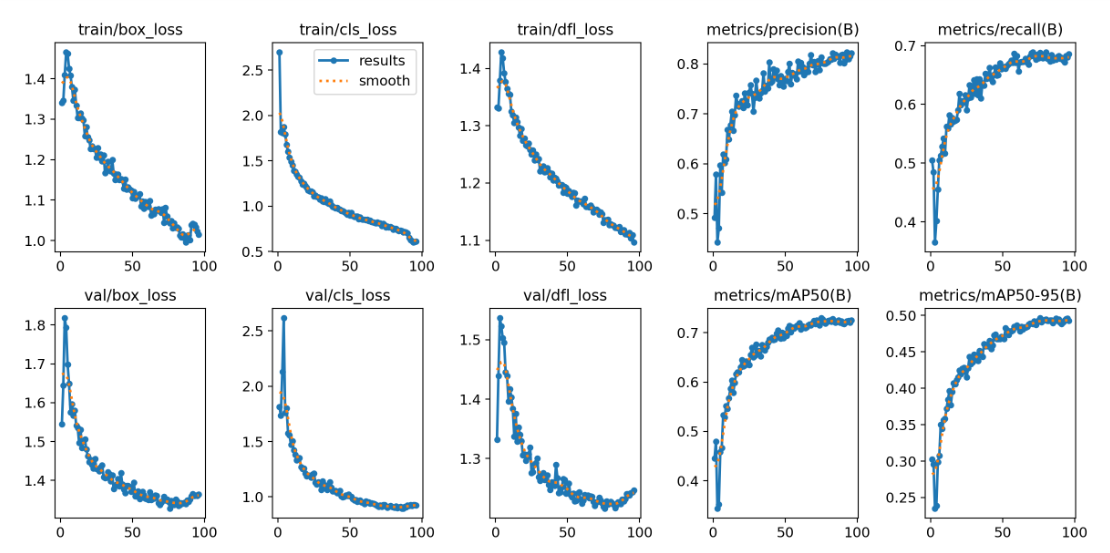

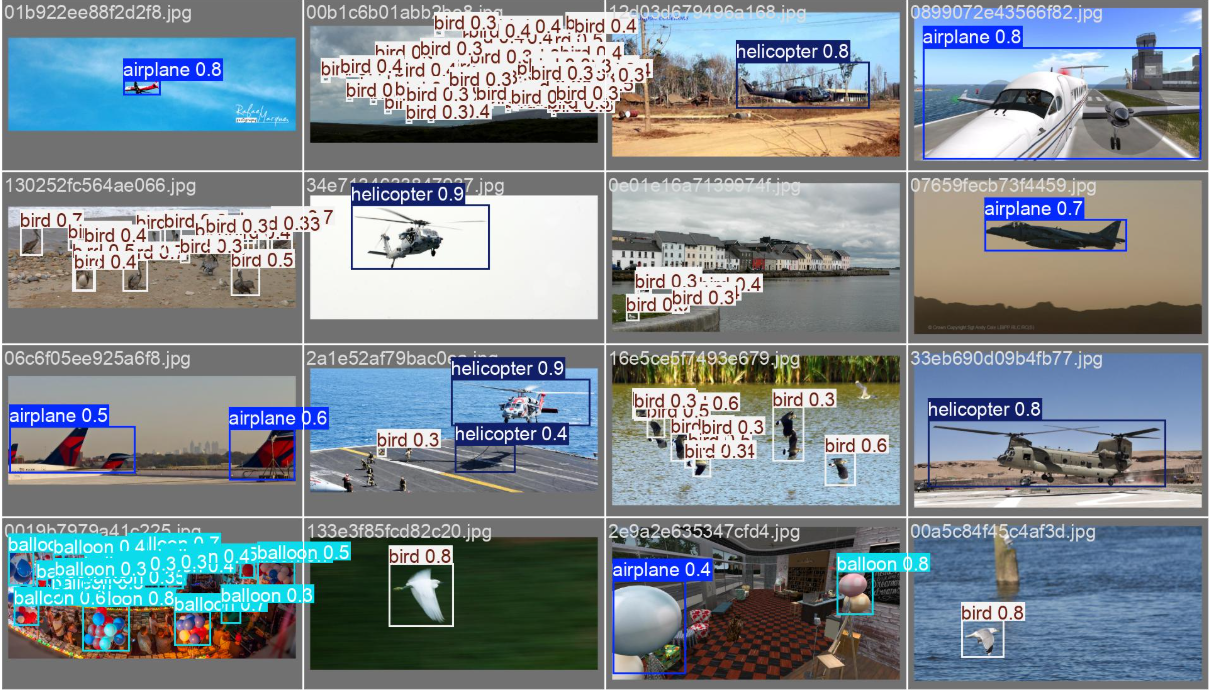

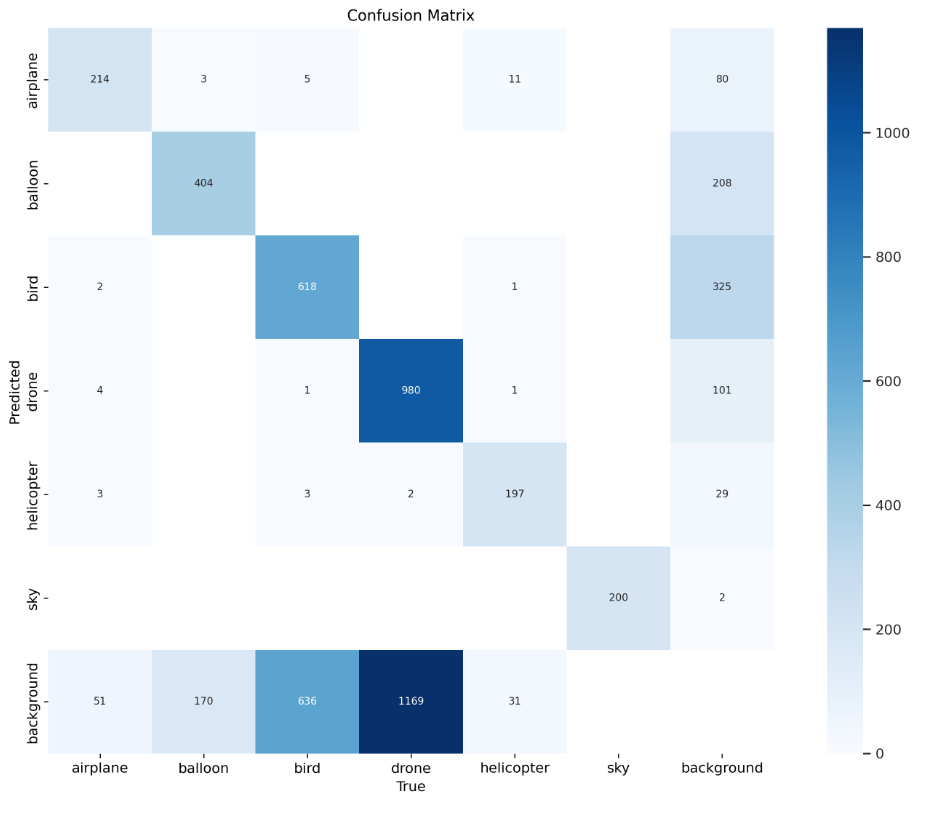

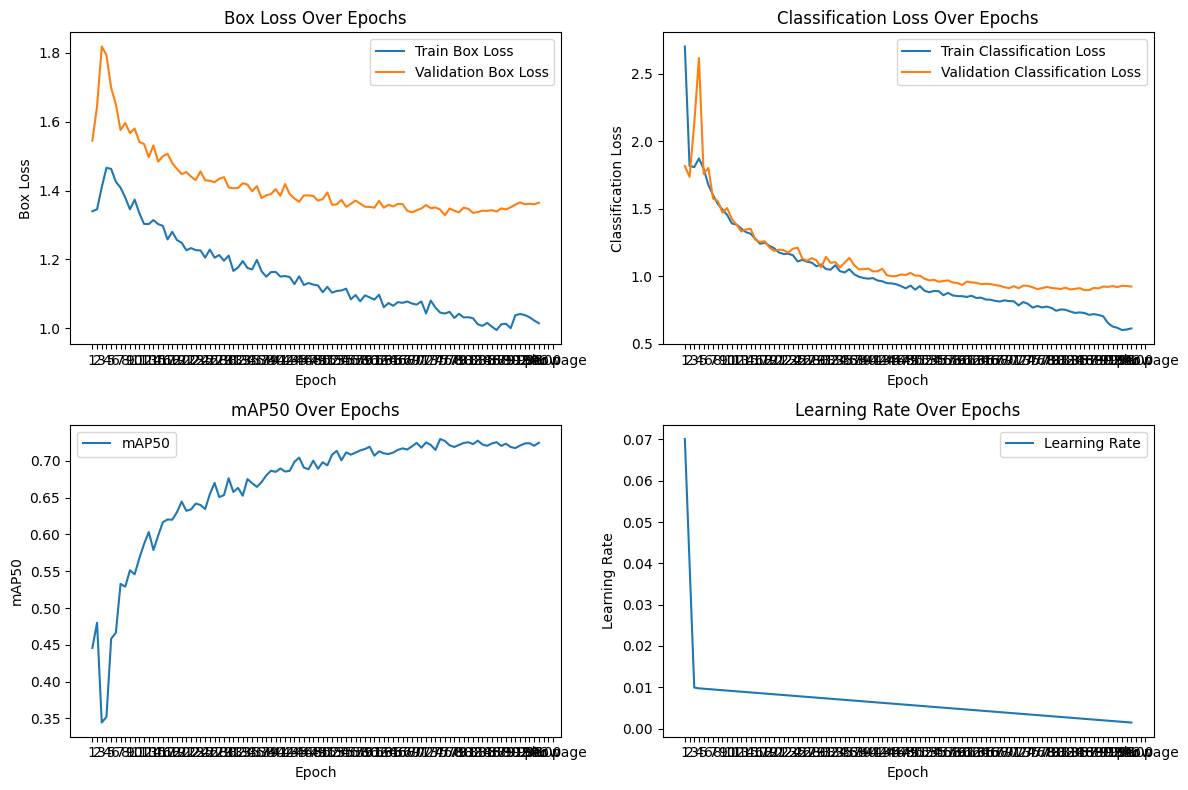

## Analiza Metryk
1. Box Loss
Trening: Box loss systematycznie spada, co wskazuje na poprawę lokalizacji obiektów w bounding boxach.

- Walidacja: Box loss dla walidacji jest wyższy niż dla treningu, co może sugerować lekkie przeuczenie modelu lub różnice między danymi treningowymi a walidacyjnymi.

2. Classification Loss
Trening: Classification loss spada stabilnie, co oznacza, że model coraz lepiej klasyfikuje obiekty.

- Walidacja: Walidacyjna strata klasyfikacji jest zbliżona do treningowej, co wskazuje na dobrą generalizację.

3. mAP50 (Mean Average Precision przy IoU=0.5)
mAP50 rośnie stabilnie i osiąga wartość około 0.72 pod koniec treningu. Jest to dobry wynik dla detekcji obiektów powietrznych, szczególnie przy ograniczonej liczbie danych.

4. Learning Rate
Learning rate zmniejsza się zgodnie z harmonogramem, co pomaga modelowi w stopniowym dopasowywaniu wag.

### Podsumowanie Wyników
| Metryka |	Wartość Końcowa |
| - | - |
| Final Train Box Loss |	~1.03 |
| Final Validation Box Loss |	~1.12 |
| Final Train Classification Loss |	~0.74 |
| Final Validation Classification Loss |	~0.75 |
| Final mAP50|	~0.72 |

### Ocena Modelu
- Generalizacja: Model dobrze generalizuje, ponieważ różnice między stratami treningowymi a walidacyjnymi są niewielkie.

- Dokładność: mAP50 na poziomie 0.72 jest solidnym wynikiem dla tego typu problemu.

- Przeuczenie: Nie ma wyraźnych oznak przeuczenia, ale wyższy box loss dla walidacji może wymagać dalszej analizy.